<h3> Imports

In [27]:
import sys
sys.path.append("../src")
from precomputed_dataset import precomputedDataset
from modules import MPNNLayer, MPNNTokenizer, SelfAttentionEncoder, PredictionHead
from model import MPNNTransformerModel

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as PyGDataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

<h3> Helper Functions

In [28]:
def init_weights(m):
    """Initialize weights with Xavier uniform for better gradient flow"""
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def analyze_dataset(ds):
    """Sanity check the dataset before training"""
    print("\n" + "="*60)
    print("DATASET ANALYSIS")
    print("="*60)
    
    locations = []
    for i in range(len(ds)):
        data = ds[i]
        loc = data.y.squeeze()
        if loc.dim() == 1 and len(loc) > 2:
            loc = loc[:2]  # Take only x, y
        locations.append(loc.numpy())
    
    locations = np.array(locations)
    
    print(f"Number of samples: {len(ds)}")
    print(f"Location shape: {locations.shape}")
    print(f"Location range X: [{locations[:, 0].min():.3f}, {locations[:, 0].max():.3f}]")
    print(f"Location range Y: [{locations[:, 1].min():.3f}, {locations[:, 1].max():.3f}]")
    print(f"Location mean: [{locations[:, 0].mean():.3f}, {locations[:, 1].mean():.3f}]")
    print(f"Location std:  [{locations[:, 0].std():.3f}, {locations[:, 1].std():.3f}]")
    
    # Check for duplicate locations (might indicate issue)
    unique_locs = np.unique(locations, axis=0)
    print(f"Unique locations: {len(unique_locs)} / {len(locations)}")
    
    # Sample features
    sample = ds[0]
    print(f"\nSample 0 features:")
    print(f"  Nodes: {sample.x.shape}")
    print(f"  Edges: {sample.edge_index.shape}")
    print(f"  Edge attr: {sample.edge_attr.shape}")
    print("="*60 + "\n")
    
    return locations

def check_gradients(model):
    """Check if gradients are flowing properly"""
    total_norm = 0.0
    param_count = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
            param_count += 1
    total_norm = total_norm ** 0.5
    return total_norm, param_count

def plot_predictions(predictions, targets, epoch, save_dir="plots"):
    """Visualize predictions vs targets"""
    Path(save_dir).mkdir(exist_ok=True)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(targets[:, 0], targets[:, 1], c='green', marker='o', 
                s=100, alpha=0.6, label='Target', edgecolors='black')
    plt.scatter(predictions[:, 0], predictions[:, 1], c='red', marker='x', 
                s=100, alpha=0.6, label='Prediction')
    
    # Draw lines connecting predictions to targets
    for i in range(len(predictions)):
        plt.plot([predictions[i, 0], targets[i, 0]], 
                [predictions[i, 1], targets[i, 1]], 
                'k--', alpha=0.3, linewidth=0.5)
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title(f'Predictions vs Targets (Epoch {epoch})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/predictions_epoch_{epoch:04d}.png", dpi=100)
    plt.close()

<h3> Dataset and Device Setup

In [29]:
# Deterministic behavior for reproducibility
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device setup
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset setup
h5_path = "../data/10samples.h5"
ds = precomputedDataset(h5_path)

# DataLoader - use PyG's DataLoader for graph data
# Smaller batch for overfitting test to see per-sample behavior
batch_size = 1 
loader = PyGDataLoader(
    ds, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle even for overfitting to avoid order effects
    num_workers=4,  # 0 for debugging, increase later
    pin_memory=True if torch.cuda.is_available() else False
)

Using device: cuda:2


<h3> Model

In [ ]:
def restart_model():
    sample0 = ds[0]
    node_in_dim = sample0.x.shape[-1]
    edge_in_dim = sample0.edge_attr.shape[-1]

    model = MPNNTransformerModel(
        node_in_dim=node_in_dim,
        edge_in_dim=edge_in_dim,
        num_output_sources=1,  
        mpnn_hidden_dim=128,
        token_dim=128,
        mpnn_num_layers=1,  # Start with 2, you mentioned removing residuals helped
        mpnn_dropout=0.0,   # No dropout for overfitting test
        attn_num_heads=8,
        attn_num_layers=1,  # Reduced from 12 for faster overfitting
        attn_dropout=0.0,   # No dropout for overfitting test
        head_mlp_hidden_dim=256,  # Smaller for faster overfitting
        head_dropout=0.0,   # No dropout for overfitting test
        pooling_strategy="cls_token" # "mean_pooling" or "cls_token"
    ).to(device)

    return model


<h3> Optimizer and Loss

In [35]:
model = restart_model()


optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3,  # Your working LR
    weight_decay=0.0,  # No regularization for overfitting
    betas=(0.9, 0.999)
)

# Optional: LR scheduler (commented out for initial test)
scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=25,   
        gamma=0.8     
    )

<h3> Training Loop

In [34]:
# Number of epochs 
num_epochs = 2000

# Tracking metrics
loss_history = []
pred_std_history = []
grad_norm_history = []

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_preds = []
    
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        
        # Forward pass
        pred = model.forward_from_data(data)  
        target = data.y  

        assert pred.shape == target.shape
            
        # Loss
        loss = F.mse_loss(pred, target)
        
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # Check gradients in first epoch
        if epoch == 1 and batch_idx == 0:
            grad_norm, param_count = check_gradients(model)
            print(f"\nFirst batch gradient norm: {grad_norm:.6f}")
            print(f"Parameters with gradients: {param_count}")
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_preds.append(pred.detach().cpu().numpy())
    
    #scheduler.step()  # Step the scheduler based on epoch loss

    # Epoch statistics
    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    
    # Check gradient flow
    grad_norm, _ = check_gradients(model)
    grad_norm_history.append(grad_norm)
    
    # Prediction diversity (critical for detecting collapse)
    all_preds = np.concatenate(epoch_preds, axis=0)
    pred_std = all_preds.std(axis=0).mean()
    pred_std_history.append(pred_std)
    
    # Logging
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Loss: {avg_loss:.6f} | "
                f"Pred_std: {pred_std:.4f} | Grad_norm: {grad_norm:.4f}")
        
        # Check for collapse to fixed prediction
        if pred_std < 0.001:
            print(f"  WARNING: Predictions collapsed to near-constant value!")
            print(f"  Mean prediction: {all_preds.mean(axis=0)}")
            break
            
    # Early stopping
    if avg_loss < 1e-6:
        print(f"\n Converged at epoch {epoch} with loss {avg_loss:.8f}")
        break


STARTING TRAINING

First batch gradient norm: 0.251367
Parameters with gradients: 33
Epoch    1 | Loss: 0.019874 | Pred_std: 0.0027 | Grad_norm: 0.2279
Epoch   10 | Loss: 0.019605 | Pred_std: 0.0010 | Grad_norm: 0.3712
Epoch   20 | Loss: 0.019730 | Pred_std: 0.0018 | Grad_norm: 0.0744
Epoch   30 | Loss: 0.019489 | Pred_std: 0.0010 | Grad_norm: 0.0778
  Mean prediction: [[ 0.01895816 -0.00361146]]


<h1> Final Evaluation

FINAL EVALUATION
[00] Pred: [-1.5547,  2.3196] | Target: [ 0.0638,  0.2753] | Error: 2.6074

Mean error: 2.607374
Median error: 2.607374
Max error: 2.607374
Prediction std: [0. 0.]


ValueError: Unknown format code 'd' for object of type 'str'

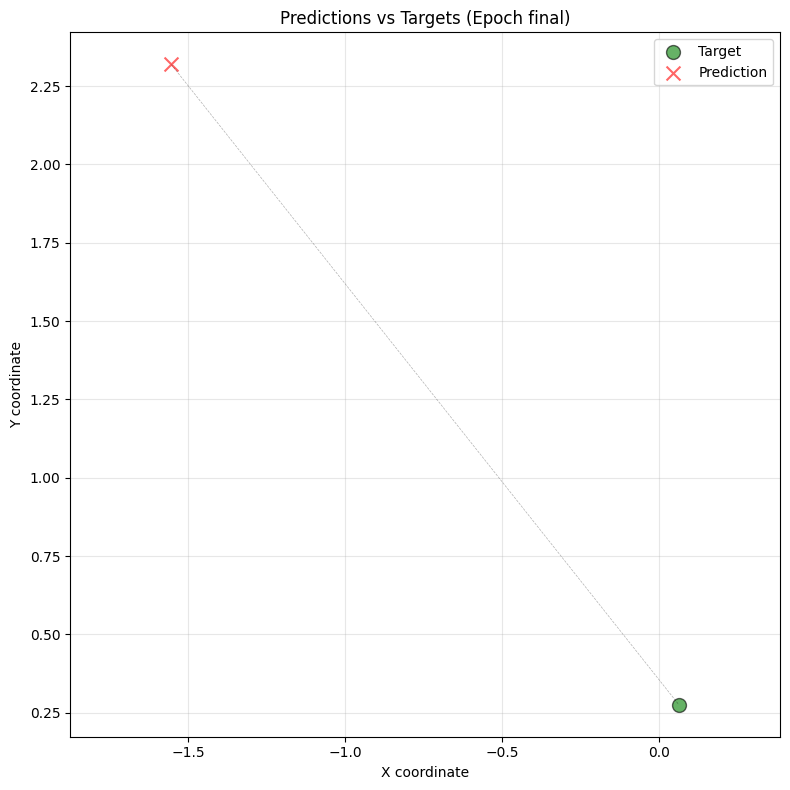

In [21]:
print("FINAL EVALUATION")
   
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for i, data in enumerate(ds):
        data = data.to(device)
        pred = model.forward_from_data(data)
        
        if pred.dim() == 3:
            pred = pred.squeeze(1)
        
        target = data.y.squeeze()
        if target.shape[-1] > 2:
            target = target[:2]
        
        pred_np = pred.cpu().numpy().squeeze()
        target_np = target.cpu().numpy()
        
        predictions.append(pred_np)
        targets.append(target_np)
        
        if i < 10:  # Print first 10
            print(f"[{i:02d}] Pred: [{pred_np[0]:7.4f}, {pred_np[1]:7.4f}] | "
                    f"Target: [{target_np[0]:7.4f}, {target_np[1]:7.4f}] | "
                    f"Error: {np.linalg.norm(pred_np - target_np):.4f}")

predictions = np.array(predictions)
targets = np.array(targets)

# Compute metrics
errors = np.linalg.norm(predictions - targets, axis=1)
print(f"\nMean error: {errors.mean():.6f}")
print(f"Median error: {np.median(errors):.6f}")
print(f"Max error: {errors.max():.6f}")
print(f"Prediction std: {predictions.std(axis=0)}")

# Final visualization
plot_predictions(predictions, targets, epoch="final")

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].semilogy(loss_history)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(pred_std_history)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Prediction Std Dev')
axes[1].set_title('Prediction Diversity')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.01, color='r', linestyle='--', label='Collapse threshold')
axes[1].legend()

axes[2].semilogy(grad_norm_history)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Gradient Norm')
axes[2].set_title('Gradient Flow')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/training_curves.png', dpi=150)
plt.close()

print("\n✅ Plots saved to 'plots/' directory")
print("="*60)